# Projet télédétection
Audrey Zimmer

Zone d'étude : Bretagne 2023 - 2024

Objectif : 

## 1. Import des librairies

In [3]:
# Librairies python
import sys
sys.path.append('..')
import os
from sklearn.model_selection import train_test_split
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
from osgeo import ogr
from osgeo import gdal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Librairies personnelles
from libsigma import classification as cla
from libsigma import read_and_write as rw
from libsigma import plots


## Création des dossiers

In [ ]:
# Chemin de base (absolu)
my_folder = "/home/onyxia/work/Projet_teledetection"


# Chemins des dossiers à créer (absolus)
results_path = os.path.join(my_folder, "../results")
figure_path = os.path.join(my_folder, "../results/figure")
img_path = os.path.join(my_folder, "img")


# Création des dossiers
os.makedirs(results_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)
os.makedirs(img_path, exist_ok=True)

print("Dossiers results, figure et img créés avec succès !")


# Paramètres
dates = ['19-07-2024', '07-06-2024', '18-04-2024', '19-01-2024', '08-10-2023']
bandes = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']


# Fichiers d'entrée 
path_b3 = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B03.tif" 
path_b5 = "/home/onyxia/work/data/projet_eval/bretagne_23-24_B05.tif"
path_vecteur = "/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp"


print("Configuration prête. Les sorties seront définies dans les blocs suivants.")


Dossiers results, figure et img créés avec succès !


## Formatage des données

In [ ]:
# Dictionnaire pour stocker les datasets
datasets = {}

# Vérification des dimensions
for bande in bandes:
    chemin = f'/home/onyxia/work/data/projet_eval/bretagne_23-24_{bande}.tif'
    
    # 1. Ouverture de l'image et stockage dans dataset 
    datasets[bande] = rw.open_image(chemin)
    
    print(f"Bande {bande}:")
    
    # 2. Obtention des informations de colonnes, de lignes et de bandes des données
    rw.get_image_dimension(datasets[bande], verbose=True)
    print("-" * 20) # Séparateur pour la lisibilité

Bande B02:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B03:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B04:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B05:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B06:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B07:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B08:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B8A:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B11:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------
Bande B12:
Number of columns : 1533
Number of lines : 612
Number of bands : 5
--------------------


Toutes les bandes obtenues ont la même dimension : 
- 1533 colonnes
- 612 lignes
- 5 bandes

## Analyse des échantillons
### Nombre d'échantillons

In [ ]:
# Calcul de l'emprise spatiale des données 

# 1. Ouvrir l'image de référence
ds = rw.open_image(path_b3)

# 2. Récupérer les dimensions (Lignes, Colonnes)
nb_lignes, nb_col, _ = rw.get_image_dimension(ds)

# 3. Récupérer l'origine (X_min, Y_max)
# Dans GDAL, l'origine est le coin SUPÉRIEUR gauche
origin_x, origin_y = rw.get_origin_coordinates(ds)

# 4. Récupérer la taille du pixel
# psize_y est généralement négatif car on descend dans l'image
psize_x, psize_y = rw.get_pixel_size(ds)

# 5. Calculer les bornes de l'emprise
x_min = origin_x
x_max = origin_x + (nb_col * psize_x)

y_max = origin_y
y_min = origin_y + (nb_lignes * psize_y) 

# Affichage des résultats
print("--- Emprise des données ---")
print(f"X Min (Ouest) : {x_min:.2f}")
print(f"X Max (Est)   : {x_max:.2f}")
print(f"Y Min (Sud)   : {y_min:.2f}")
print(f"Y Max (Nord)  : {y_max:.2f}")
print("-" * 27)

In [ ]:
# --- ANALYSE DES ÉCHANTILLONS ---

# 1. Chargement du fichier
gdf = gpd.read_file(path_vecteur)

# 2. Préparation des données pour le diagramme
polygon_counts = gdf['strate'].value_counts().reset_index()
polygon_counts.columns = ['Classe', 'Nombre de polygones']
polygon_counts['Classe'] = polygon_counts['Classe'].astype(str)

# On s'assure d'avoir les 4 classes pour la cohérence visuelle
all_classes = pd.DataFrame({'Classe': ['1', '2', '3', '4']})
polygon_counts = all_classes.merge(polygon_counts, on='Classe', how='left').fillna(0)
polygon_counts['Nom'] = polygon_counts['Classe'].map({'1': 'Sol nu', '2': 'Herbe', '3': 'Landes', '4': 'Arbre'})

# 3. Création du diagramme de répartition
fig_polygons = px.bar(
    polygon_counts,
    x='Classe',
    y='Nombre de polygones',
    color='Classe',
    color_discrete_map={'1': '#F5DEB3', '2': '#98FB98', '3': '#32CD32', '4': '#228B22'},
    title='Répartition des polygones d\'échantillonnage par classe',
    hover_data=['Nom'],
    category_orders={'Classe': ['1', '2', '3', '4']}
)

fig_polygons.update_xaxes(tickvals=['1', '2', '3', '4'], ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre'])

# 4. Enregistrement
output_polygon_html = os.path.join(figure_path, 'diag_baton_nb_poly_by_class.html')
fig_polygons.write_html(output_polygon_html)
fig_polygons.show()

print(f"Analyse des échantillons terminée. Nombre total de polygones : {len(gdf)}")

Analyse des échantillons terminée. Nombre total de polygones : 278


La classe 1 (sol nu) est absente des 

### Nombre de pixels par classe

In [ ]:
# --- Rasterisation ---

# 1. Définition du fichier de sortie (Ici et maintenant)
output_strates_raster = os.path.join(results_path, "PI_strates_bretagne_32630_raster.tif")

# 2. Paramètres de l'emprise (déjà calculés)
xmin, ymin, xmax, ymax = 432950.0, 5362770.0, 448280.0, 5368890.0 # Emprise du raster calculée précédemment
res = 10 # Résolution 10m

# 3. Commande de rasterisation
cmd = (f"gdal_rasterize -a strate -tr {res} {res} "
       f"-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
       f"{path_vecteur} {output_strates_raster}")

print(f"Création de : {output_strates_raster}")
os.system(cmd)

if os.path.exists(output_strates_raster):
    print("Le masque des strates est prêt.")

In [ ]:
# --- NOMBRE DE PIXELS PAR STRATE ---

# 1. Chargement du raster que tu viens de créer au Bloc 3
# On utilise ta fonction rw pour charger l'image en array
raster_array = rw.load_img_as_array(output_strates_raster)

# 2. Comptage des pixels par classe
unique, counts = np.unique(raster_array, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# Exclure la classe 0 (fond/NoData)
pixel_counts.pop(0, None)

# 3. Création du DataFrame de synthèse
all_classes = pd.DataFrame({'Classe': [1, 2, 3, 4]})
pixel_df = pd.merge(
    all_classes,
    pd.DataFrame({'Classe': list(pixel_counts.keys()), 'Nombre de pixels': list(pixel_counts.values())}),
    on='Classe',
    how='left'
).fillna(0)

# 4. Configuration visuelle
color_map = {1: '#F5DEB3', 2: '#98FB98', 3: '#32CD32', 4: '#228B22'}
noms_strates_complet = {1: 'Sol nu', 2: 'Herbe', 3: 'Landes', 4: 'Arbre'}

# 5. Création du graphique unique et homogène
fig_pixels = go.Figure()

for classe in pixel_df['Classe']:
    count = pixel_df[pixel_df['Classe'] == classe]['Nombre de pixels'].values[0]
    fig_pixels.add_trace(go.Bar(
        x=[classe],
        y=[count],
        marker_color=color_map[classe],
        name=noms_strates_complet[classe],
        text=int(count), # Affiche le nombre au-dessus de la barre
        textposition='auto',
    ))

# Mise à jour du design
fig_pixels.update_layout(
    title='Distribution spatiale : Nombre de pixels par classe',
    xaxis_title='Type de strate',
    yaxis_title='Nombre de pixels',
    xaxis=dict(
        tickvals=[1, 2, 3, 4],
        ticktext=['Sol nu', 'Herbe', 'Landes', 'Arbre'],
        type='category'
    ),
    template='plotly_white',
    showlegend=True
)

# 6. Enregistrement (Utilise le chemin figure_path défini au Bloc 1)
output_pixel_html = os.path.join(figure_path, 'diag_baton_nb_pix_by_class.html')
fig_pixels.write_html(output_pixel_html)

# Affichage
fig_pixels.show()

print(f"Statistiques de pixels sauvegardées dans : {output_pixel_html}")

✅ Statistiques de pixels sauvegardées dans : /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.html


## Phénologie des strates, mise en évidence des landes

In [ ]:
# --- Calcul ARI ---

# 1. Définition du fichier de sortie
output_ari_path = os.path.join(results_path, "ARI_serie_temp.tif")

# 2. Chargement des données via rw
print("Chargement des bandes...")
arr_b3 = rw.load_img_as_array(path_b3).astype(np.float32)
arr_b5 = rw.load_img_as_array(path_b5).astype(np.float32)

# 3. Calcul mathématique
with np.errstate(divide='ignore', invalid='ignore'):
    # Formule ARI : ((1/B03)-(1/B05)) / ((1/B03)+(1/B05))
    inv_b3 = 1.0 / arr_b3
    inv_b5 = 1.0 / arr_b5
    ari_stack = (inv_b3 - inv_b5) / (inv_b3 + inv_b5)

# Nettoyage NoData
ari_stack = np.nan_to_num(ari_stack, nan=-9999, posinf=-9999, neginf=-9999)

# 4. Écriture avec rw
ds_ref = rw.open_image(path_b3)
rw.write_image(output_ari_path, ari_stack, data_set=ds_ref, gdal_dtype=gdal.GDT_Float32)

print(f"ARI enregistré : {output_ari_path}")

Chargement des bandes...
ARI enregistré : /home/onyxia/work/results/ARI_serie_temp.tif


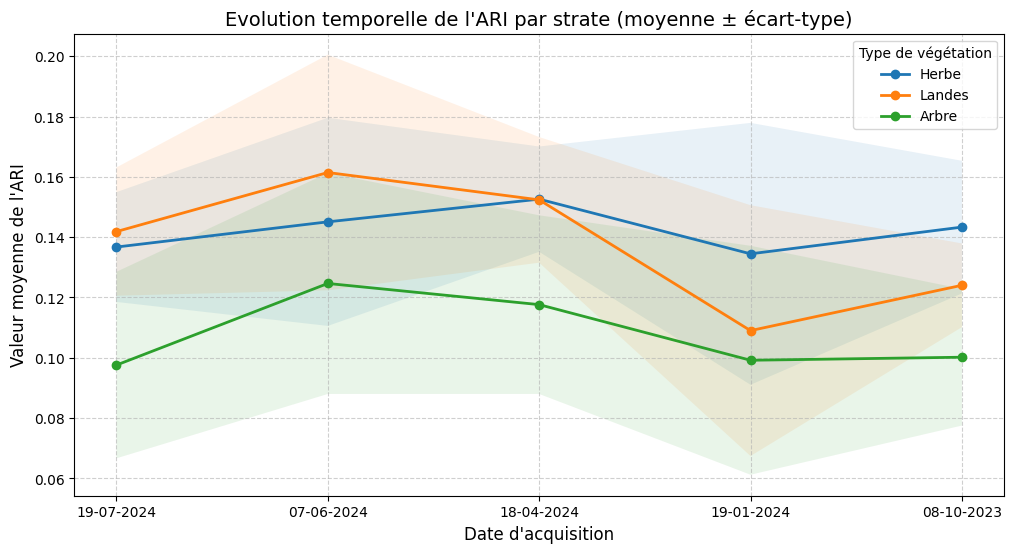

Graphique mis à jour sauvegardé : /home/onyxia/work/results/figure/ARI_series.png


In [ ]:
# --- Statistiques et Visualisation ---

# 1. Définition du dictionnaire de correspondance
noms_strates = {
    2: "Herbe",
    3: "Landes",
    4: "Arbre"
}

output_graphique = os.path.join(figure_path, "ARI_series.png")

# 2. Extraction des échantillons par strate (via cla)
dict_X, Y, dict_t = cla.get_samples_from_roi(
    raster_name=output_ari_path,
    roi_name=output_strates_raster,
    output_fmt='by_label'
)

# 3. Création du graphique
plt.figure(figsize=(12, 6))
x_axis = np.arange(len(dates))

for label, pixels in dict_X.items():
    # On récupère le nom propre via le dictionnaire, sinon on garde le chiffre
    nom_label = noms_strates.get(label, f"Strate {label}")
    
    # Nettoyage NoData et calcul
    valid_pixels = np.where(pixels == -9999, np.nan, pixels)
    means = np.nanmean(valid_pixels, axis=0)
    stds = np.nanstd(valid_pixels, axis=0)
    
    # On utilise nom_label pour la légende
    plt.plot(x_axis, means, label=nom_label, marker='o', linewidth=2)
    plt.fill_between(x_axis, means-stds, means+stds, alpha=0.1)

# Mise en forme finale
plt.xticks(x_axis, dates)
plt.title("Evolution temporelle de l'ARI par strate (moyenne ± écart-type)", fontsize=14)
plt.xlabel("Date d'acquisition", fontsize=12)
plt.ylabel("Valeur moyenne de l'ARI", fontsize=12)
plt.legend(title="Type de végétation")
plt.grid(True, linestyle='--', alpha=0.6)

# Sauvegarde
plt.savefig(output_graphique, dpi=300, bbox_inches='tight')
plt.show()

print(f"Graphique mis à jour sauvegardé : {output_graphique}")

# Production d'une carte de strates à l'échelle du pixel
## Choix du classifieur et sa paramétrisation

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import geopandas as gpd
from osgeo import gdal, ogr, osr


In [ ]:
# Charger le fichier de formes (shapefile) avec les classes
gdf = gpd.read_file('/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp')

# Lire le fichier raster avec les bandes spectrales
dataset = gdal.Open('/home/onyxia/work/results/ARI_serie_temp.tif')
band_count = dataset.RasterCount

# Initialiser les listes pour stocker les données et les étiquettes
X = []
y = []

# Créer un système de coordonnées basé sur EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)

# Parcourir chaque polygone dans le shapefile
for index, row in gdf.iterrows():
    # Récupérer la géométrie du polygone
    geom = row['geometry']

    # Créer un masque pour le polygone
    mem_drv = ogr.GetDriverByName('Memory')
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', srs=srs, geom_type=ogr.wkbPolygon)

    # Créer une feature et définir sa géométrie
    feature = ogr.Feature(mem_layer.GetLayerDefn())
    ogr_geom = ogr.CreateGeometryFromWkb(geom.wkb)
    feature.SetGeometry(ogr_geom)
    mem_layer.CreateFeature(feature)
    feature = None

    # Créer un raster en mémoire pour le masque
    target_ds = gdal.GetDriverByName('MEM').Create('', dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(dataset.GetGeoTransform())
    target_ds.SetProjection(srs.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.Fill(0)
    band.SetNoDataValue(0)

    # Rasteriser le polygone
    gdal.RasterizeLayer(target_ds, [1], mem_layer, burn_values=[1])

    # Lire le masque rasterisé
    mask_array = band.ReadAsArray()

    # Extraire les valeurs des bandes spectrales pour les pixels dans le polygone
    for band_num in range(1, band_count + 1):
        band = dataset.GetRasterBand(band_num)
        band_array = band.ReadAsArray()

        # Extraire les valeurs des pixels qui sont dans le masque
        pixel_values = band_array[mask_array == 1]
        valid_pixels = pixel_values[pixel_values != -9999]

        # Ajouter les valeurs des bandes pour chaque pixel valide
        if band_num == 1:
            X_temp = valid_pixels.reshape(-1, 1)
        else:
            X_temp = np.column_stack((X_temp, valid_pixels))

    # Ajouter les étiquettes de classe pour chaque pixel valide
    if 'X_temp' in locals():
        X.extend(X_temp)
        y.extend([row['strate']] * len(X_temp))

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Forme de X_train:", X_train.shape)
print("Forme de y_train:", y_train.shape)
print("Forme de X_test:", X_test.shape)
print("Forme de y_test:", y_test.shape)


In [ ]:
# Initialiser le modèle RandomForest
rf = RandomForestClassifier(random_state=0)

# Définition de la grille d'hyperparamètres
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],  # Nombre d'arbres dans la forêt
    "max_depth": [None, 10, 15, 20],     # Profondeur maximale des arbres
    "max_features": [None, "sqrt", "log2"], # Nombre de variables testées à chaque split
    "min_samples_leaf": [1, 5]       # Nombre minimal d’échantillons dans une feuille
}

# Cross-validation stratifiée avec K=5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Grille de recherche
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1  # utilise tous les CPU pour aller plus vite
)

# Entraînement avec recherche des meilleurs hyperparamètres
grid.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres trouvés :")
print(grid.best_params_)

# Score moyen de la cross-validation
print(f"Score CV moyen : {grid.best_score_:.2f}")

# Modèle final (entraîné sur tout le train)
best_model = grid.best_estimator_

# Évaluation sur le test
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)

print(f"Accuracy test : {acc_test:.2f}")

# Afficher un rapport de classification détaillé
from sklearn.metrics import classification_report
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


**Interprétation des résultats** :

max_depth : 20 : Les arbres ont une profondeur maximale de 20.

max_features : sqrt : Le modèle utilise la racine carrée du nombre total de caractéristiques à chaque division.

min_samples_leaf : 1 : Chaque feuille peut contenir un seul échantillon.

n_estimators : 300 : Le modèle utilise 300 arbres.

---

Classe 2 : Précision de 0.98 et rappel de 0.97.

Classe 3 : Précision de 0.94 et rappel de 0.93.

Classe 4 : Précision de 0.89 et rappel de 0.91.


### Stratégie de validation

Les classes ici sont relativement équilibrées (respectivement 1044, 1545 et 1229 pixels pour les classes 2, 3 et 4). Le type de validation choisi est donc le StratifiedKFold qui permet de conserver la proportion des classes, rendant cette méthode indispensable dans le cas de classes déséquilibrées. Bien que relativement équilibrées, les classes de cette étude ne le sont pas parfaitement. Ainsi, afin d'éviter un biais, le type de validation choisi est le StratifiedKFold. 

Le jeu de données ayant une taille modérée (3818 pixels), la valeur de K choisie est 5, afin que la stratégie de validation soit à la fois robuste et moins coûteuse en temps. 



In [ ]:
# Charger le fichier de formes (shapefile) avec les classes
gdf = gpd.read_file('/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp')

# Lire le fichier raster avec les bandes spectrales
dataset = gdal.Open('/home/onyxia/work/results/.tif')
band_count = dataset.RasterCount

# Initialiser les listes pour stocker les données et les étiquettes
X = []
y = []

# Créer un système de coordonnées basé sur EPSG:32630
srs = osr.SpatialReference()
srs.ImportFromEPSG(32630)

# Parcourir chaque polygone dans le shapefile
for index, row in gdf.iterrows():
    # Récupérer la géométrie du polygone
    geom = row['geometry']

    # Créer un masque pour le polygone
    mem_drv = ogr.GetDriverByName('Memory')
    mem_ds = mem_drv.CreateDataSource('out')
    mem_layer = mem_ds.CreateLayer('poly', srs=srs, geom_type=ogr.wkbPolygon)

    # Créer une feature et définir sa géométrie
    feature = ogr.Feature(mem_layer.GetLayerDefn())
    ogr_geom = ogr.CreateGeometryFromWkb(geom.wkb)
    feature.SetGeometry(ogr_geom)
    mem_layer.CreateFeature(feature)
    feature = None

    # Créer un raster en mémoire pour le masque
    target_ds = gdal.GetDriverByName('MEM').Create('', dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(dataset.GetGeoTransform())
    target_ds.SetProjection(srs.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.Fill(0)
    band.SetNoDataValue(0)

    # Rasteriser le polygone
    gdal.RasterizeLayer(target_ds, [1], mem_layer, burn_values=[1])

    # Lire le masque rasterisé
    mask_array = band.ReadAsArray()

    # Extraire les valeurs des bandes spectrales pour les pixels dans le polygone
    for band_num in range(1, band_count + 1):
        band = dataset.GetRasterBand(band_num)
        band_array = band.ReadAsArray()

        # Extraire les valeurs des pixels qui sont dans le masque
        pixel_values = band_array[mask_array == 1]
        valid_pixels = pixel_values[pixel_values != -9999]

        # Ajouter les valeurs des bandes pour chaque pixel valide
        if band_num == 1:
            X_temp = valid_pixels.reshape(-1, 1)
        else:
            X_temp = np.column_stack((X_temp, valid_pixels))

    # Ajouter les étiquettes de classe pour chaque pixel valide
    if 'X_temp' in locals():
        X.extend(X_temp)
        y.extend([row['strate']] * len(X_temp))

# Convertir X et y en tableaux numpy
X = np.array(X)
y = np.array(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Forme de X_train:", X_train.shape)
print("Forme de y_train:", y_train.shape)
print("Forme de X_test:", X_test.shape)
print("Forme de y_test:", y_test.shape)


In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, classification_report, \
    accuracy_score
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# personal librairies
import classification as cla
import read_and_write as rw
import plots

# 1 --- define parameters
# inputs
#my_folder = '/home/mlang/Documents/Enseignement/cours/online/stable/data/td_M2_classif'
sample_filename = os.path.join(my_folder, 'sample_strata.tif')
image_filename = os.path.join(my_folder, 'aumelas_orthoirc.tif')
id_filename = os.path.join(my_folder, 'sample_strata_id.tif')

# Sample parameters
#test_size = 0.7
nb_iter = 30
nb_folds = 5
is_point = False
# if is_point is True
field_name = 'num'

# outputs
suffix = '_CV{}folds_stratified_group_x{}times'.format(nb_folds, nb_iter)
out_folder = os.path.join(my_folder, 'results')
out_classif = os.path.join(out_folder, 'ma_classif{}.tif'.format(suffix))
out_matrix = os.path.join(out_folder, 'ma_matrice{}.png'.format(suffix))
out_qualite = os.path.join(out_folder, 'mes_qualites{}.png'.format(suffix))


# 2 --- extract samples
if not is_point :
    X, Y, t = cla.get_samples_from_roi(image_filename, sample_filename)
    _, groups, _ = cla.get_samples_from_roi(image_filename, id_filename)
else :
    # get X
    list_row, list_col = rw.get_row_col_from_file(sample_filename, image_filename)
    image = rw.load_img_as_array(image_filename)
    X = image[(list_row, list_col)]

    # get Y
    gdf = gpd.read_file(sample_filename)
    Y = gdf.loc[:, field_name].values
    Y = np.atleast_2d(Y).T

list_cm = []
list_accuracy = []
list_report = []
groups = np.squeeze(groups)

# Iter on stratified K fold
for _ in range(nb_iter):
  kf = StratifiedGroupKFold(n_splits=nb_folds, shuffle=True)
  for train, test in kf.split(X, Y, groups=groups):
      X_train, X_test = X[train], X[test]
      Y_train, Y_test = Y[train], Y[test]

      # 3 --- Train
      #clf = SVC(cache_size=6000)
      clf = tree.DecisionTreeClassifier()
      clf.fit(X_train, Y_train)

      # 4 --- Test
      Y_predict = clf.predict(X_test)

      # compute quality
      list_cm.append(confusion_matrix(Y_test, Y_predict))
      list_accuracy.append(accuracy_score(Y_test, Y_predict))
      report = classification_report(Y_test, Y_predict,
                                     labels=np.unique(Y_predict),
                                     output_dict=True)

      # store them
      list_report.append(report_from_dict_to_df(report))

# compute mean of cm
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# compute mean and std of overall accuracy
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# compute mean and std of classification report
array_report = np.array(list_report)
mean_report = array_report.mean(axis=0)
std_report = array_report.std(axis=0)
a_report = list_report[0]
mean_df_report = pd.DataFrame(mean_report, index=a_report.index,
                              columns=a_report.columns)
std_df_report = pd.DataFrame(std_report, index=a_report.index,
                             columns=a_report.columns)

# Display confusion matrix
plots.plot_cm(mean_cm, np.unique(Y_predict))
plt.savefig(out_matrix, bbox_inches='tight')

# Display class metrics
fig, ax = plt.subplots(figsize=(10, 7))
ax = mean_df_report.T.plot.bar(ax=ax, yerr=std_df_report.T, zorder=2)
ax.set_ylim(0.5, 1)
_ = ax.text(1.5, 0.95, 'OA : {:.2f} +- {:.2f}'.format(mean_accuracy,
                                                      std_accuracy),
            fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
              linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
              linewidth=0.3, zorder=1)
plt.savefig(out_qualite, bbox_inches='tight')


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, osr

# Scikit-learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Importation de tes librairies personnelles ---
# Assure-toi qu'elles sont dans le même dossier ou dans le PYTHONPATH
import read_and_write as rw
import plots
# On n'importe pas 'classification' ici car on va gérer l'extraction 
# spécifiquement pour gérer les 'groups' en mémoire sans dépendre d'OTB.

# ==============================================================================
# 1. PARAMÈTRES ET CHEMINS
# ==============================================================================

# Chemins (à adapter selon ta session)
work_dir = '/home/onyxia/work'
image_filename = os.path.join(work_dir, 'results/ARI_serie_temp.tif')      # Tes variables (X)
label_filename = os.path.join(work_dir, 'results/output_strates.tif')      # Tes classes rasterisées (y)
shapefile_path = os.path.join(work_dir, 'data/projet_eval/PI_strates_bretagne_32630.shp')
output_dir = os.path.join(work_dir, 'results/classification')

# Création du dossier de sortie s'il n'existe pas
os.makedirs(output_dir, exist_ok=True)

# Paramètres de validation
NB_FOLDS = 5           # K=5 plis
NB_ITER = 30           # 30 répétitions pour la robustesse (Monte Carlo)
CLASSES_LABELS = ['Sol nu', 'Herbe', 'Landes', 'Arbre']
CLASSES_VALUES = [1, 2, 3, 4] # Valeurs pixel correspondantes

# ==============================================================================
# 2. CRÉATION DU RASTER DE GROUPES (ID POLYGONE)
# ==============================================================================
# Pour le StratifiedGroupKFold, il nous faut savoir à quel polygone appartient chaque pixel.
# On va rasteriser l'ID unique (FID) du shapefile.

print("--- Création du raster d'identifiants de polygones (Groupes) ---")

# Ouvrir le shapefile
gdf_source = ogr.Open(shapefile_path)
layer = gdf_source.GetLayer()

# Récupérer les infos du raster de référence (pour avoir la même grille)
ref_ds = gdal.Open(image_filename)
geo_transform = ref_ds.GetGeoTransform()
projection = ref_ds.GetProjection()
x_size = ref_ds.RasterXSize
y_size = ref_ds.RasterYSize

# Créer un raster temporaire en mémoire pour les IDs
target_ds = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_UInt32)
target_ds.SetGeoTransform(geo_transform)
target_ds.SetProjection(projection)

# Initialiser à 0
band = target_ds.GetRasterBand(1)
band.Fill(0)
band.SetNoDataValue(0)

# Rasteriser en utilisant le FID (Identifiant unique du polygone)
# L'option "ATTRIBUTE=FID" n'existant pas toujours directement, on utilise l'index SQL
gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=FID"])

# Lire le raster de groupes en array
groups_array = band.ReadAsArray()
print("Raster de groupes généré en mémoire.")

# ==============================================================================
# 3. EXTRACTION DES DONNÉES (X, y, groups)
# ==============================================================================
print("--- Chargement des données et extraction ---")

# Chargement des images via ta lib rw
img_array = rw.load_img_as_array(image_filename)  # (Lignes, Cols, Bandes)
label_array = rw.load_img_as_array(label_filename) # (Lignes, Cols)

# On applatit les images pour travailler pixel par pixel
# Dimensions : (Nombre_Pixels_Total, Nombre_Bandes)
n_rows, n_cols, n_bands = img_array.shape
X_flat = img_array.reshape(-1, n_bands)
y_flat = label_array.flatten()
groups_flat = groups_array.flatten()

# Masque : On ne garde que les pixels qui ont une classe connue (exclure le fond 0)
mask = y_flat > 0

# Application du masque
X = X_flat[mask]
y = y_flat[mask]
groups = groups_flat[mask]

print(f"Données extraites : {X.shape[0]} pixels valides pour l'entraînement.")
print(f"Nombre de groupes (polygones) uniques : {len(np.unique(groups))}")

# ==============================================================================
# 4. OPTIMISATION (GridSearch)
# ==============================================================================
print("\n--- Phase 1 : Optimisation des hyperparamètres ---")

# Paramètres à tester
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "max_features": ["sqrt"],
    "min_samples_leaf": [1, 5]
}

# Validation Croisée Groupée
cv_grid = StratifiedGroupKFold(n_splits=NB_FOLDS, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv_grid,
    scoring='f1_weighted', # Metrique adaptée au déséquilibre
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y, groups=groups)

best_params = grid.best_params_
print(f"Meilleurs hyperparamètres : {best_params}")

# ==============================================================================
# 5. ÉVALUATION ROBUSTE (Monte Carlo avec tes librairies)
# ==============================================================================
print(f"\n--- Phase 2 : Évaluation statistique ({NB_ITER} itérations) ---")

list_cm = []
list_accuracy = []
list_report = [] # Nécessaire pour plots.plot_mean_class_quality

# Fonction utilitaire pour convertir le rapport dict en DataFrame (format attendu par plots.py)
def report_from_dict_to_df(report):
    return pd.DataFrame(report).transpose()

for i in range(NB_ITER):
    if i % 5 == 0: print(f"Itération {i}/{NB_ITER}...")
    
    # Validation croisée groupée avec seed changeante
    kf = StratifiedGroupKFold(n_splits=NB_FOLDS, shuffle=True, random_state=i)
    
    # On prend juste le premier split de chaque itération pour le Monte Carlo
    # (ou on boucle sur les folds, ici on simplifie pour suivre la logique itérative)
    train_idx, test_idx = next(kf.split(X, y, groups=groups))
        
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Entraînement
    clf = RandomForestClassifier(**best_params, random_state=i, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # Prédiction
    y_pred = clf.predict(X_test)
    
    # Calcul des métriques
    # Attention: labels=CLASSES_VALUES assure que la matrice a la bonne taille même si une classe manque
    list_cm.append(confusion_matrix(y_test, y_pred, labels=CLASSES_VALUES))
    list_accuracy.append(accuracy_score(y_test, y_pred))
    
    report_dict = classification_report(y_test, y_pred, labels=CLASSES_VALUES, 
                                        target_names=CLASSES_LABELS, output_dict=True, zero_division=0)
    list_report.append(report_from_dict_to_df(report_dict))

# Moyennes
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# Sauvegarde et affichage avec TA LIBRAIRIE PLOTS
out_matrix_path = os.path.join(output_dir, 'matrice_confusion_mean.png')
out_qualite_path = os.path.join(output_dir, 'qualite_classes_mean.png')

print("Génération des graphiques...")

# 1. Matrice de confusion (Normalisée en %)
plots.plot_cm(
    mean_cm, 
    labels=CLASSES_LABELS, 
    out_filename=out_matrix_path, 
    normalize=True,  # Pour avoir des pourcentages
    cmap='Greens'
)

# 2. Qualité par classe (Barplots avec écart-types)
plots.plot_mean_class_quality(
    list_report, 
    list_accuracy, 
    out_filename=out_qualite_path
)

print(f"Graphiques sauvegardés dans : {output_dir}")

# ==============================================================================
# 6. PRODUCTION DE LA CARTE FINALE
# ==============================================================================
print("\n--- Phase 3 : Production de la carte finale (Inférence) ---")

# 1. Ré-entraîner le modèle sur TOUTES les données disponibles
final_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X, y)

# 2. Prédiction sur l'image entière
# Attention à la mémoire : on prédit par blocs si l'image est géante, 
# mais ici X_flat devrait tenir en mémoire.
print("Prédiction sur l'ensemble de l'image...")

# X_flat contient tous les pixels (y compris le fond/NoData)
# Il faut gérer le NoData lors de la prédiction
# On remplace les NaN ou valeurs aberrantes temporairement pour ne pas crasher, 
# puis on remasquera
X_final = np.nan_to_num(X_flat, nan=0.0) 

# Prédiction
y_final_flat = final_model.predict(X_final)

# 3. Remettre en forme (Lignes, Colonnes)
classification_map = y_final_flat.reshape(n_rows, n_cols)

# 4. Sauvegarde avec TA LIBRAIRIE RW
output_tif = os.path.join(output_dir, 'Carte_Strates_Predite.tif')

# On récupère les infos géographiques du fichier source
dataset_ref = rw.open_image(image_filename)

rw.write_image(
    out_filename=output_tif,
    array=classification_map,
    data_set=dataset_ref,     # Copie proj et geotransform depuis la source
    gdal_dtype=gdal.GDT_Byte  # Type Byte suffisant pour classes 1,2,3,4
)

print(f"Carte de classification sauvegardée : {output_tif}")
print("Terminé avec succès.")

### Test classif

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from osgeo import gdal, ogr

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



# ==============================================================================
# 1. PARAMÈTRES ET CHEMINS
# ==============================================================================
work_dir = '/home/onyxia/work'

# LISTE DE TES ENTRÉES (X) - Ajoute ici tous tes fichiers
image_files = [
    os.path.join(work_dir, 'results/S2_stack.tif'),      # Image multi-bandes
    os.path.join(work_dir, 'results/ARI_serie_temp.tif') # Indice ARI
]

label_filename = os.path.join(work_dir, 'results/output_strates.tif')      # Ton raster de classes (y)
shapefile_path = os.path.join(work_dir, 'data/projet_eval/PI_strates_bretagne_32630.shp')
output_dir = os.path.join(work_dir, 'results/classification')
os.makedirs(output_dir, exist_ok=True)

# Paramètres de l'étude
NB_FOLDS = 5
NB_ITER = 10 # Tu peux mettre 30 pour la version finale, 10 pour tester
CLASSES_LABELS = ['Sol nu', 'Herbe', 'Landes', 'Arbre']
CLASSES_VALUES = [1, 2, 3, 4]

# ==============================================================================
# 2. RASTÉRISATION DES GROUPES (FID DES POLYGONES)
# ==============================================================================
print("--- Etape 2 : Création des groupes (ID polygones) ---")
ref_ds = gdal.Open(image_files[0])
target_ds = gdal.GetDriverByName('MEM').Create('', ref_ds.RasterXSize, ref_ds.RasterYSize, 1, gdal.GDT_UInt32)
target_ds.SetGeoTransform(ref_ds.GetGeoTransform())
target_ds.SetProjection(ref_ds.GetProjection())

# On rasterise le FID (l'identifiant unique de chaque polygone du shapefile)
source_ds = ogr.Open(shapefile_path)
layer = source_ds.GetLayer()
gdal.RasterizeLayer(target_ds, [1], layer, options=["ATTRIBUTE=FID"])
groups_array = target_ds.GetRasterBand(1).ReadAsArray()

--- Etape 2 : Création des groupes (ID polygones) ---


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
ERROR 4: /home/onyxia/work/results/S2_stack.tif: No such file or directory


AttributeError: 'NoneType' object has no attribute 'RasterXSize'

In [5]:
# --- TEST DE DIAGNOSTIC ---
for f in image_files:
    if os.path.exists(f):
        print(f"✅ Trouvé : {f}")
    else:
        print(f"❌ INTROUVABLE : {f}")

# Vérifie aussi le label et le shapefile
if not os.path.exists(label_filename): print(f"❌ INTROUVABLE : {label_filename}")
if not os.path.exists(shapefile_path): print(f"❌ INTROUVABLE : {shapefile_path}")

❌ INTROUVABLE : /home/onyxia/work/results/S2_stack.tif
✅ Trouvé : /home/onyxia/work/results/ARI_serie_temp.tif
❌ INTROUVABLE : /home/onyxia/work/results/output_strates.tif


--- Etape 2 : Création des groupes (ID polygones) ---
Champs trouvés dans le shapefile : ['id', 'strate', 'comment']
Utilisation du champ 'id' pour les groupes.
Nombre de groupes (polygones) détectés : 98
--- Etape 3 : Assemblage de 5 fichiers en RAM ---
   -> Chargement de : ARI_serie_temp.tif
   -> Chargement de : bretagne_23-24_B02.tif
   -> Chargement de : bretagne_23-24_B03.tif
   -> Chargement de : bretagne_23-24_B04.tif
   -> Chargement de : bretagne_23-24_B08.tif
Extraction terminée : 3839 pixels prêts pour l'entraînement.
--- Etape 4 : Optimisation et Validation Croisée Groupée ---
Meilleurs paramètres trouvés : {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Lancement de 10 itérations d'évaluation...
Évaluation terminée avec succès.


/home/onyxia/work/Projet_teledetection/../libsigma/plots.py:197: RuntimeWarning: invalid value encountered in divide
  precision = cm.diagonal() / cm.sum(axis=0) * 100
/home/onyxia/work/Projet_teledetection/../libsigma/plots.py:198: RuntimeWarning: invalid value encountered in divide
  recall = cm.diagonal() / cm.sum(axis=1) * 100
/home/onyxia/work/Projet_teledetection/../libsigma/plots.py:207: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


--- Etape 5 : Production de la carte finale ---
Traitement terminé ! Carte sauvegardée dans : /home/onyxia/work/results/Carte_Strates_Bretagne_2024.tif


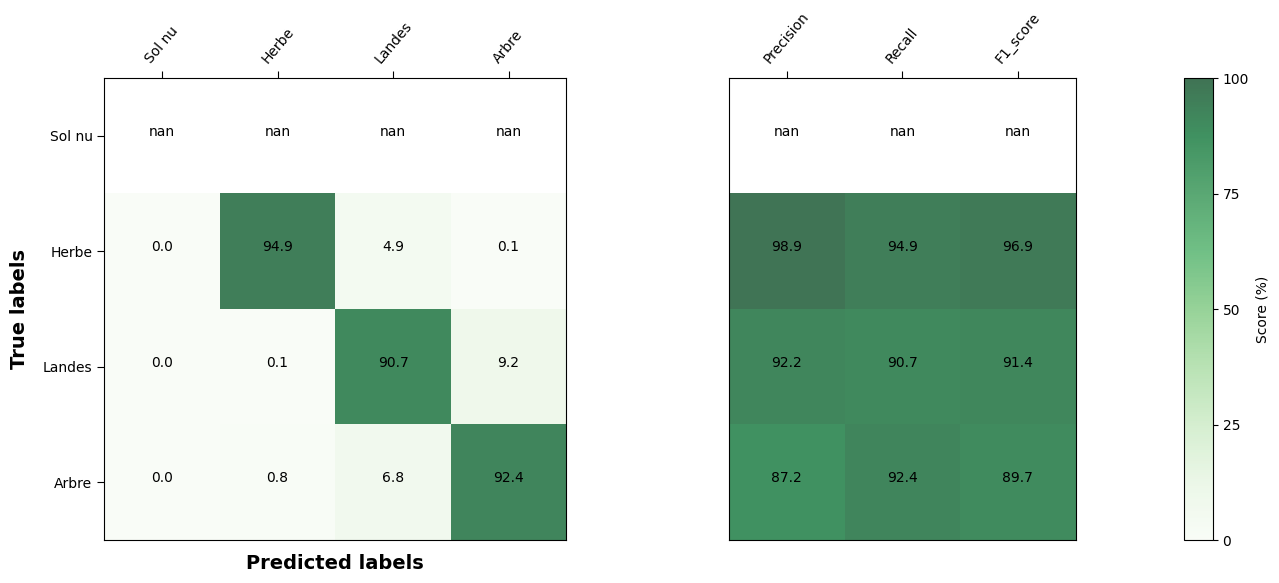

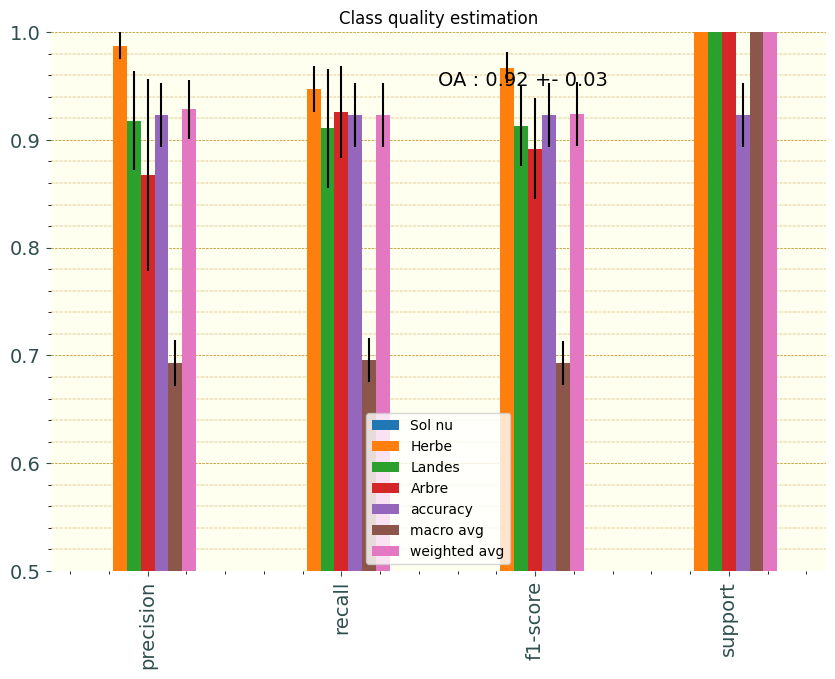

In [9]:
import os
import numpy as np
import pandas as pd
from osgeo import gdal, ogr

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score



# ==============================================================================
# 1. CONFIGURATION DES CHEMINS
# ==============================================================================
work_dir = '/home/onyxia/work'

# --- LISTE DES FICHIERS D'ENTRÉE (À compléter avec ta liste) ---
# Ajoute ici tous les fichiers que tu veux que le modèle utilise pour apprendre
fichiers_entree = [
    os.path.join(work_dir, 'results/ARI_serie_temp.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B02.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B03.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B04.tif'),
    os.path.join(work_dir, 'data/projet_eval/bretagne_23-24_B08.tif'),
    # Ajoute les autres bandes ici...
]

# Ton fichier de vérité terrain (rasterisé précédemment)
label_filename = os.path.join(work_dir, 'results/PI_strates_bretagne_32630_raster.tif')

# Ton fichier vecteur (pour créer les groupes de polygones)
shapefile_path = os.path.join(work_dir, 'data/projet_eval/PI_strates_bretagne_32630.shp')

output_dir = os.path.join(work_dir, 'results/figure')
os.makedirs(output_dir, exist_ok=True)

# Paramètres
NB_FOLDS = 5
NB_ITER = 10 # Tu peux monter à 30 pour la version finale
CLASSES_LABELS = ['Sol nu', 'Herbe', 'Landes', 'Arbre']
CLASSES_VALUES = [1, 2, 3, 4]

# ==============================================================================
# 2. RASTÉRISATION DES GROUPES (VERSION ROBUSTE)
# ==============================================================================
print("--- Etape 2 : Création des groupes (ID polygones) ---")
ref_ds = gdal.Open(fichiers_entree[0])
target_ds = gdal.GetDriverByName('MEM').Create('', ref_ds.RasterXSize, ref_ds.RasterYSize, 1, gdal.GDT_UInt32)
target_ds.SetGeoTransform(ref_ds.GetGeoTransform())
target_ds.SetProjection(ref_ds.GetProjection())

source_ds = ogr.Open(shapefile_path)
layer = source_ds.GetLayer()

# --- NOUVEAU : On cherche un champ d'ID existant ou on utilise l'index interne ---
defn = layer.GetLayerDefn()
field_names = [defn.GetFieldDefn(i).GetName() for i in range(defn.GetFieldCount())]
print(f"Champs trouvés dans le shapefile : {field_names}")

# On cherche un champ qui pourrait servir d'ID (souvent 'ID', 'id', 'OBJECTID')
id_field = None
for candidate in ['id', 'ID', 'OBJECTID', 'objectid', 'pk']:
    if candidate in field_names:
        id_field = candidate
        break

if id_field:
    print(f"Utilisation du champ '{id_field}' pour les groupes.")
    gdal.RasterizeLayer(target_ds, [1], layer, options=[f"ATTRIBUTE={id_field}"])
else:
    # Si aucun champ d'ID n'est trouvé, on utilise l'index interne du Shapefile (plus lent mais infaillible)
    print("Aucun champ ID trouvé, utilisation de l'index interne des entités...")
    for feat in layer:
        # On brûle chaque polygone un par un avec son propre FID interne
        gdal.RasterizeLayer(target_ds, [1], layer, 
                           selection=f"FID={feat.GetFID()}", 
                           burn_values=[feat.GetFID()])
    layer.ResetReading()

groups_array = target_ds.GetRasterBand(1).ReadAsArray()

# VERIFICATION : Combien de groupes différents avons-nous ?
n_groups = len(np.unique(groups_array))
print(f"Nombre de groupes (polygones) détectés : {n_groups}")

# ==============================================================================
# 3. ASSEMBLAGE DES BANDES EN MÉMOIRE (RAM)
# ==============================================================================
print(f"--- Etape 3 : Assemblage de {len(fichiers_entree)} fichiers en RAM ---")

list_arrays = []
for f in fichiers_entree:
    print(f"   -> Chargement de : {os.path.basename(f)}")
    arr = rw.load_img_as_array(f)
    if len(arr.shape) == 2:
        arr = arr[:, :, np.newaxis]
    list_arrays.append(arr)

# On colle toutes les bandes ensemble
img_stack = np.concatenate(list_arrays, axis=2)
label_array = rw.load_img_as_array(label_filename)

# Mise à plat pour Scikit-Learn
n_rows, n_cols, n_bands = img_stack.shape
X_flat = img_stack.reshape(-1, n_bands)
y_flat = label_array.flatten()
groups_flat = groups_array.flatten()

# Masque : on ne garde que les pixels d'échantillonnage (y de 1 à 4)
mask = np.isin(y_flat, CLASSES_VALUES)
X_clean = X_flat[mask]
y_clean = y_flat[mask]
groups_clean = groups_flat[mask]

print(f"Extraction terminée : {X_clean.shape[0]} pixels prêts pour l'entraînement.")

# ==============================================================================
# 4. OPTIMISATION ET VALIDATION CROISÉE
# ==============================================================================

print("--- Etape 4 : Optimisation et Validation Croisée Groupée ---")

# Recherche des meilleurs paramètres (GridSearch)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, None],
    "max_features": ["sqrt"]
}

cv_group = StratifiedGroupKFold(n_splits=NB_FOLDS, shuffle=True, random_state=42)
grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, cv=cv_group, scoring='f1_weighted')
grid.fit(X_clean, y_clean, groups=groups_clean)

best_params = grid.best_params_
print(f"Meilleurs paramètres trouvés : {best_params}")

# Évaluation statistique (Monte Carlo)
list_cm, list_accuracy, list_report = [], [], []


print(f"Lancement de {NB_ITER} itérations d'évaluation...")

for i in range(NB_ITER):
    kf = StratifiedGroupKFold(n_splits=NB_FOLDS, shuffle=True, random_state=i)
    train_idx, test_idx = next(kf.split(X_clean, y_clean, groups=groups_clean))
    
    clf = RandomForestClassifier(**best_params, n_jobs=-1)
    clf.fit(X_clean[train_idx], y_clean[train_idx])
    y_pred = clf.predict(X_clean[test_idx])
    
    # Stockage des résultats
    list_cm.append(confusion_matrix(y_clean[test_idx], y_pred, labels=CLASSES_VALUES))
    list_accuracy.append(accuracy_score(y_clean[test_idx], y_pred))
    
    # LA CORRECTION EST ICI : on ajoute labels=CLASSES_VALUES
    report = classification_report(
        y_clean[test_idx], 
        y_pred, 
        labels=CLASSES_VALUES,    # Force à chercher les 4 classes
        target_names=CLASSES_LABELS, 
        output_dict=True,
        zero_division=0           # Évite les warnings si une classe est absente
    )
    list_report.append(pd.DataFrame(report).transpose())

print("Évaluation terminée avec succès.")




# Visualisation avec TES LIBRAIRIES
plots.plot_cm(np.array(list_cm).mean(axis=0), labels=CLASSES_LABELS, 
              out_filename=os.path.join(output_dir, 'matrice_confusion.png'), normalize=True)
plots.plot_mean_class_quality(list_report, list_accuracy, 
                              out_filename=os.path.join(output_dir, 'qualite_classes.png'))

# ==============================================================================
# 5. PRÉDICTION DE LA CARTE FINALE
# ==============================================================================
print("--- Etape 5 : Production de la carte finale ---")

# Entraînement final sur TOUT l'échantillonnage
final_model = RandomForestClassifier(**best_params, n_jobs=-1)
final_model.fit(X_clean, y_clean)

# Prédiction sur l'image entière
# nan_to_num remplace les pixels vides par 0 pour éviter les erreurs
y_final_flat = final_model.predict(np.nan_to_num(X_flat))
classification_map = y_final_flat.reshape(n_rows, n_cols)

# Sauvegarde avec TA LIBRAIRIE RW
output_tif = os.path.join(work_dir, 'results/Carte_Strates_Bretagne_2024.tif')
rw.write_image(
    out_filename=output_tif,
    array=classification_map,
    data_set=ref_ds,
    gdal_dtype=gdal.GDT_Byte
)

print(f"Traitement terminé ! Carte sauvegardée dans : {output_tif}")